# San Francisco Traffic Accident Frequency
## Miguel Candido Aurora Peralta
### Transformative AI for Residential and Transportation Safety Vertically Integrated Project
### Spring 2024 Senior Capstone Project <br><br>

# Imports

In [126]:
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import json
import requests

import folium

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import (Input, LSTM, Dense, Concatenate,
                          TimeDistributed, Reshape, RepeatVector, Dropout)



# Getting data
## Traffic Accident Data
Data obtained from  SFGov's dataset titled "Traffic Crashes Resulting in Injury" from 1/1/2005 to 12/31/2023.

About the data, including column descriptions: https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx/about_data

In [2]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
df=pd.read_csv('gdrive/My Drive/crashes.csv')

<ipython-input-3-01903bcfc559>:1: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('gdrive/My Drive/crashes.csv')


## Weather

In [4]:
# Retrieving daily data for max temp, min temp, average temp, and precipitation
def get_weather_data():

  # Generate the range of dates
  start_date = datetime(2005, 1, 1)
  end_date = datetime(2023, 12, 31)
  one_day = timedelta(days=1)
  date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

  # Initialize DataFrame
  weather_df = pd.DataFrame(index=date_range)

  # Codes for max temp, min temp, average temp, and precipitation
  elements = {'max_temp':'1', 'min_temp':'2', 'avg_temp':'43', 'precip':'4'}

  for key, val in elements.items():
    # RCIS API call
    url = "http://data.rcc-acis.org/"
    input_dict = {
        "sid":"USW00023272 6",
        "sdate":"2005-01-01",
        "edate":"2023-12-31",
        "elems":val,
        "output":"json"}
    params = {'params': json.dumps(input_dict)}
    headers = {'Accept': 'application/json'}
    req = requests.post('http://data.rcc-acis.org/StnData', data=params, headers=headers)
    response = req.json()
    response_data = [item[1] for item in response['data']]

    # Store in dataframe
    weather_df[key] = response_data

  return weather_df

In [5]:
raw_weather_df = get_weather_data()
# Replace "M" with NaN
raw_weather_df.replace("M", np.nan, inplace=True)

# Convert to numeric
raw_weather_df = raw_weather_df.apply(pd.to_numeric, errors='ignore')

# Impute with the median for each column
weather_df = raw_weather_df.fillna(raw_weather_df.median())

print(weather_df.head())

            max_temp  min_temp  avg_temp  precip
2005-01-01      54.0      45.0      49.5    0.37
2005-01-02      47.0      46.0      46.5    0.93
2005-01-03      54.0      44.0      49.0    0.03
2005-01-04      53.0      44.0      48.5    0.04
2005-01-05      51.0      46.0      48.5    0.03


# Removing unnecessary data and checking datatypes

In [6]:
# Selecting necessary columns
df = df[["collision_datetime", "collision_date", "accident_year", "month", "day_of_week", 'tb_latitude', 'tb_longitude']]

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58262 entries, 0 to 58261
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   collision_datetime  58262 non-null  object 
 1   collision_date      58262 non-null  object 
 2   accident_year       58262 non-null  int64  
 3   month               58262 non-null  object 
 4   day_of_week         58254 non-null  object 
 5   tb_latitude         58064 non-null  float64
 6   tb_longitude        58064 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.1+ MB
None


In [8]:
df.head()

,collision_datetime,collision_date,accident_year,month,day_of_week,tb_latitude,tb_longitude
0,12/18/2023 02:15:00 PM,2023 December 18,2023,December,Monday,37.743586,-122.463710
1,01/20/2015 10:07:00 AM,2015 January 20,2015,January,Tuesday,37.781750,-122.396380
2,04/23/2013 11:26:00 AM,2013 April 23,2013,April,Tuesday,37.761830,-122.503878
3,08/22/2007 10:30:00 PM,2007 August 22,2007,August,Wednesday,37.783992,-122.408066
4,09/03/2009 01:35:00 PM,2009 September 03,2009,September,Thursday,37.785291,-122.424770


In [9]:
df["collision_datetime"]

0        12/18/2023 02:15:00 PM
1        01/20/2015 10:07:00 AM
2        04/23/2013 11:26:00 AM
3        08/22/2007 10:30:00 PM
4        09/03/2009 01:35:00 PM
                  ...          
58257    07/12/2012 11:48:00 AM
58258    06/10/2023 11:03:00 PM
58259    10/19/2021 08:25:00 PM
58260    01/09/2012 08:25:00 AM
58261    04/05/2023 07:41:00 AM
Name: collision_datetime, Length: 58262, dtype: object

In [10]:
# Casting accident year to int
df['accident_year'] = df['accident_year'].astype(int)

# Casting datetime to datetime object
df['collision_datetime'] = pd.to_datetime(df["collision_datetime"],
                                          format="%m/%d/%Y %I:%M:%S %p")
df['collision_date'] = pd.to_datetime(df["collision_datetime"],
                                      format="%Y-%m-%d").dt.date

# Casting month and day of week to numeric format
df['month'] = pd.to_datetime(df['month'], format='%B').dt.month
df['day_of_week'] = pd.to_datetime(df['day_of_week'], format='%A').dt.dayofweek

# Renaming latitude and longitude columns for convenience
df = df.rename(columns={'tb_latitude':'latitude', 'tb_longitude':'longitude'})

I will not be training the model on post-2020 data so that irregular traffic patterns caused by lockdowns in 2020 and 2021 will not affect the overall model.

accident_year  month
2005           1        245
               2        224
               3        281
               4        268
               5        299
                       ... 
2023           8        262
               9        271
               10       293
               11       245
               12       266
Length: 228, dtype: int64


<Axes: xlabel='accident_year,month'>

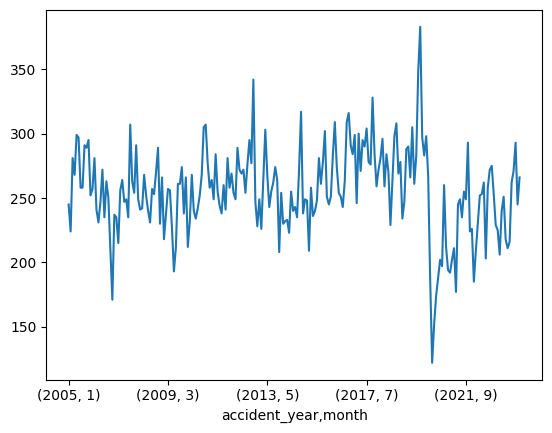

In [11]:
# Graph of accident counts by month over time
yearly_counts = df.groupby(by=['accident_year', 'month']).size()
print(yearly_counts)
yearly_counts.plot(kind='line')

In [12]:
# Subsetting data
selected_dates = df[df['accident_year'] < 2015].sort_values(by='collision_date')

# Creating map of area where accidents in dataset are occurring

In [13]:
mean_lat = selected_dates['latitude'].mean()
mean_long = selected_dates['longitude'].mean()

In [14]:
min_lat = selected_dates['latitude'].min()-.01
max_lat = selected_dates['latitude'].max()+.01
print(f"Minimum latitude: {min_lat}")
print(f"Maximum latitude: {max_lat}")


Minimum latitude: 37.69808572900908
Maximum latitude: 37.83986189124343


In [15]:
min_long = selected_dates['longitude'].min()-.01
max_long = selected_dates['longitude'].max()+.01
print(f"Minimum longitude: {min_long}")
print(f"Maximum longitude: {max_long}")



Minimum longitude: -122.52361620862789
Maximum longitude: -122.3483278940174


All possible latitude and longitude values within the city limits should fit in this area. I'll encode the accidents by assigning them to a cell in a square matrix that covers this area.

In [16]:
m = folium.Map(location=(mean_lat, mean_long),
               zoom_start=12,
               tiles='OpenStreetMap')

folium.Marker(
    location = [min_lat, min_long]
).add_to(m)
folium.Marker(
    location = [max_lat, max_long]
).add_to(m)
folium.Marker(
    location = [max_lat, min_long]
).add_to(m)
folium.Marker(
    location = [min_lat, max_long]
).add_to(m)
m

In [17]:
import numpy as np

# Generate 31 equally spaced points within the latitude and longitude ranges (30x30 grid)
lat_values = np.linspace(min_lat, max_lat, 31)
long_values = np.linspace(min_long, max_long, 31)

# Center map
mean_lat = np.mean(lat_values)
mean_long = np.mean(long_values)
m_grid = folium.Map(location=(mean_lat, mean_long), zoom_start=12, tiles='Cartodb Positron')

# Horizontal grid lines
for lat in lat_values:
    polyline = [(lat, min_long), (lat, max_long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m_grid)

# Vertical grid lines
for long in long_values:
    polyline = [(min_lat, long), (max_lat, long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m_grid)

m_grid

In [18]:
grid_boundaries = []

# Iterate through latitude values
for i in range(len(lat_values) - 1):
    lat1, lat2 = lat_values[i], lat_values[i + 1]
    # Iterate through longitude values
    for j in range(len(long_values) - 1):
        long1, long2 = long_values[j], long_values[j + 1]
        # Define the boundaries of the grid area
        boundary = [(lat1, long1), (lat1, long2), (lat2, long2), (lat2, long1), (lat1, long1)]
        # Append the boundary to the list
        grid_boundaries.append(boundary)

# Preparing data for input

In [19]:
selected_dates.dropna(subset = ['latitude', 'longitude', "month", "day_of_week"], inplace=True)
selected_dates.drop(columns = ['collision_datetime'], inplace=True)

## Creating 30x30 matrices with the accident data assigned to its respective cell in the grid

In [20]:
# Group the accidents dataframe by 'collision_date'
grouped_dates = selected_dates.groupby('collision_date')

# Create a dataframe to store the input for each data
start_date = datetime(2005, 1, 1)
end_date = datetime(2014, 12, 31)
one_day = timedelta(days=1)
date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
input_numeric = pd.DataFrame(index=date_range, columns = ['dow', 'month', 'mintemp', 'maxtemp', 'avgtemp', 'precip'])
matrices = pd.Series(index=date_range, dtype=object)

In [21]:
selected_dates.head()

,collision_date,accident_year,month,day_of_week,latitude,longitude
12370,2005-01-01,2005,1,0.0,37.780656,-122.472312
31833,2005-01-01,2005,1,0.0,37.753914,-122.483887
34111,2005-01-01,2005,1,0.0,37.771054,-122.453902
26282,2005-01-01,2005,1,0.0,37.743397,-122.475726
25233,2005-01-01,2005,1,0.0,37.789452,-122.423832


In [22]:
# Iterate through each date group from the accidents df
for date, group in grouped_dates:
    # Create a 30x30 matrix initialized with zeros
    matrix = np.zeros((30, 30), dtype=int)

    # Iterate through each row in the group
    for index, row in group.iterrows():
        # Compute the indices for the matrix
        lat_index = int((row['latitude'] - min_lat) / (max_lat - min_lat) * 30)-1
        long_index = int((row['longitude'] - min_long) / (max_long - min_long) * 30)-1

        # Increment the corresponding cell in the matrix
        matrix[lat_index, long_index] += 1

    # Store the matrix in the dataframe in the correct date
    dt_object = date.strftime('%Y-%m-%d')

    matrices.loc[dt_object] = matrix

# Add 0s for dates that were missing in grouped_dates because they had 0 accidents
matrices.replace(np.nan, 0, inplace=True)

# Replace 0s with empty matrices
for i in matrices.index:
  if isinstance(matrices.loc[i], int):
    matrices.loc[i] = np.zeros((30, 30), dtype=int)

In [23]:
# Convert to np array
matrices_array = np.array(matrices.values)

In [24]:
# Reshape into a 3d np array
matrices_3d = np.stack(matrices_array)
matrices_reshaped = matrices_3d.reshape(3652, 30, 30)

In [25]:
# Add days of week and month
input_numeric['month'] = input_numeric.index.month
input_numeric['dow'] = input_numeric.index.dayofweek

# Subset weather df
subset_weather_df = weather_df.loc[start_date:end_date]

# Add weather data
input_numeric[['mintemp', 'maxtemp', 'avgtemp', 'precip']] = subset_weather_df

# Make input suitable for LSTM

In [51]:
# Define which columns need to be scaled and one-hot encoded
numeric_features = ['mintemp', 'maxtemp', 'avgtemp', 'precip']
categorical_features = ['dow', 'month']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(categories=[range(7),
                                          range(1, 13)]),
         categorical_features)
    ],
    sparse_threshold=0)

# Fit and transform the data
input_numeric_processed = preprocessor.fit_transform(input_numeric)

In [52]:
# Flatten each 2D array
flattened_matrices = matrices_reshaped.reshape(matrices_reshaped.shape[0], -1)

# Scale/normalize the flattened data
scaler = StandardScaler()
matrices_scaled = scaler.fit_transform(flattened_matrices)

# Reshape the scaled data back to 3D
matrices_scaled_reshaped = matrices_scaled.reshape(matrices_reshaped.shape)

# The shape of the scaled and reshaped data
print("Shape of matrices_scaled_reshaped:", matrices_scaled_reshaped.shape)

Shape of matrices_scaled_reshaped: (3652, 30, 30)


# Perform train test split

In [236]:
# Perform train-test split on both input_numeric_processed and matrices_scaled_reshaped
X_train_numeric, X_test_numeric, X_train_matrices, X_test_matrices, y_train, y_test = train_test_split(input_numeric_processed, matrices_scaled_reshaped, matrices_scaled_reshaped, test_size=0.2, random_state=42)


In [237]:
print("Shape of X_train_numeric:", X_train_numeric.shape)
print("Shape of X_test_numeric:", X_test_numeric.shape)
print("Shape of X_train_matrices:", X_train_matrices.shape)
print("Shape of X_test_matrices:", X_test_matrices.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_numeric: (2921, 23)
Shape of X_test_numeric: (731, 23)
Shape of X_train_matrices: (2921, 30, 30)
Shape of X_test_matrices: (731, 30, 30)
Shape of y_train: (2921, 30, 30)
Shape of y_test: (731, 30, 30)


In [245]:
# Flatten y_train and y_test to match model's output layer
# Model outputs a flattened 30x30 matrix
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

In [252]:
y_train_reshaped = np.repeat(y_train[:, np.newaxis, :, :], 60, axis=1)
y_test_reshaped = np.repeat(y_test[:, np.newaxis, :, :], 60, axis=1)

print("Shape of y_train_reshaped:", y_train_reshaped.shape)
print("Shape of y_test_reshaped:", y_test_reshaped.shape)

Shape of y_train_reshaped: (2921, 60, 30, 30)
Shape of y_test_reshaped: (731, 60, 30, 30)


In [255]:
# Reshape y_train_reshaped
# Reshape y_train_reshaped
y_train_flat = np.reshape(y_train_reshaped, (y_train_reshaped.shape[0], -1, y_train_reshaped.shape[2] * y_train_reshaped.shape[3]))
print("Shape of y_train_flat:", y_train_flat.shape)

# Reshape y_test_reshaped
y_test_flat = np.reshape(y_test_reshaped, (y_test_reshaped.shape[0], -1, y_test_reshaped.shape[2] * y_test_reshaped.shape[3]))
print("Shape of y_test_flat:", y_test_flat.shape)

Shape of y_train_flat: (2921, 60, 900)
Shape of y_test_flat: (731, 60, 900)


# Model Architecture

In [193]:
# Define input layer for numeric data
input_numeric = Input(shape=(None, 23),
                      name='input_numeric')

# Define input layer for matrix data
input_matrices = Input(shape=(None, 30, 30),
                       name='input_matrices')
# Add a single dimension at the beginning to make it compatible with the shape
# of the numeric input
# Reshape the input to add a time dimension
reshaped_matrices = Reshape((-1, 30))(input_matrices)

In [194]:
# LSTM layer for matrix data
matrix_lstm = LSTM(units=64,
                   return_sequences=True,
                   name='matrix_lstm')(reshaped_matrices)

# Reshape input_numeric to 2D tensor to pass to RepeatVector
numeric_reshaped = Reshape((23,),
                           name='reshape_numeric')(input_numeric)

# Repeat the numeric features across the sequence dimension to match length of
# matrix_lstm output
numeric_repeated = RepeatVector(30,
                                name='repeat_numeric')(numeric_reshaped)

# Dense layer for numeric features to match the dimensionality of LSTM output
dense_numeric = Dense(units=64,
                      activation='relu',
                      name='dense_numeric')(numeric_repeated)

# Concatenate LSTM output with the repeated numeric features
concatenated = Concatenate(axis=1,
                           name='concatenated')([matrix_lstm, dense_numeric])

In [195]:
# Additional dense layers with dropout
# Helps model learn complex patterns and non-linear relationships
dense_layer_1 = Dense(units=128,
                      activation='relu',
                      name='dense_layer_1')(concatenated)
dropout_layer_1 = Dropout(0.2,
                          name='dropout_layer_1')(dense_layer_1)
dense_layer_2 = Dense(units=64,
                      activation='relu',
                      name='dense_layer_2')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2,
                          name='dropout_layer_2')(dense_layer_2)

In [257]:
# Final transformation applied to concatenated outputs of previous layers
# Produces a flattened 30x30 matrix of predicted values
output = Dense(units=900, activation='sigmoid', name='output')(dropout_layer_2)

# Define model
model = Model(inputs=[input_numeric, input_matrices],
              outputs=output,
              name='model_with_weather')

model.summary()

Model: "model_with_weather"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_numeric (InputLayer)  [(None, None, 23)]           0         []                            
                                                                                                  
 input_matrices (InputLayer  [(None, None, 30, 30)]       0         []                            
 )                                                                                                
                                                                                                  
 reshape_numeric (Reshape)   (None, 23)                   0         ['input_numeric[0][0]']       
                                                                                                  
 reshape_10 (Reshape)        (None, None, 30)             0         ['input_matri

In [258]:
# Compile the model
model.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

# Fitting model

In [259]:
history = model.fit(
    [X_train_numeric, X_train_matrices],
    y_train_flat,
    epochs=10,
    batch_size=32,
    validation_split=0.2  # 20% of the training data will be used for validation
)

Epoch 1/10
73/73 [==============================] - 10s 94ms/step - loss: 0.2871 - accuracy: 7.8482e-04 - val_loss: 0.1118 - val_accuracy: 0.0000e+00
Epoch 2/10
73/73 [==============================] - 4s 57ms/step - loss: 0.1109 - accuracy: 6.2072e-04 - val_loss: 0.1098 - val_accuracy: 0.0000e+00
Epoch 3/10
73/73 [==============================] - 4s 57ms/step - loss: 0.1099 - accuracy: 7.2774e-04 - val_loss: 0.1094 - val_accuracy: 0.0000e+00
Epoch 4/10
73/73 [==============================] - 6s 80ms/step - loss: 0.1096 - accuracy: 6.7066e-04 - val_loss: 0.1092 - val_accuracy: 0.0000e+00
Epoch 5/10
73/73 [==============================] - 4s 57ms/step - loss: 0.1095 - accuracy: 7.1347e-04 - val_loss: 0.1091 - val_accuracy: 0.0000e+00
Epoch 6/10
73/73 [==============================] - 4s 61ms/step - loss: 0.1094 - accuracy: 6.1358e-04 - val_loss: 0.1091 - val_accuracy: 0.0000e+00
Epoch 7/10
73/73 [==============================] - 6s 83ms/step - loss: 0.1094 - accuracy: 6.4926e-04 - 

In [272]:
# 1. Make predictions on the test data
y_pred = model.predict([X_test_numeric, X_test_matrices])

23/23 [==============================] - 1s 38ms/step


In [269]:
# Reshape y_test_flat and y_pred to 2D arrays so MAE will work
y_test_flat_2d = y_test_flat.reshape(-1, y_test_flat.shape[-1])
y_pred_2d = y_pred.reshape(-1, y_pred.shape[-1])


In [271]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_flat_2d, y_pred_2d)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.10813174824792841


In [261]:
print("Shape of y_pred:", y_pred.shape)

Shape of y_pred: (731, 60, 900)


In [ ]:
pred_sum = np.sum(predictions, axis=0)
actual_sum = np.sum(y_test, axis=0)
train_sum = np.sum(input_matrices, axis=0)
plt.subplot(1, 3, 1)
plt.imshow(pred_sum)

plt.subplot(1, 3, 2)
plt.imshow(actual_sum)

plt.subplot(1, 3, 3)
plt.imshow(train_sum)

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
mae

# Evaluating performance of the model
Problem: How to evaluate the performance of a neural network that outputs a 30x30 matrix?
MSE and MAE are only considering the values in the matrix, not the location of the values.

## Potential approach:
- Comparing monthly estimates to actual monthly outcomes.
- Sum all of the matrices for predicted month and actual month.
- Convert summed matrices to 30x30 image.
- Calculate the structural similarity index between the actual and predicted images.

In [ ]:
import numpy as np

In [ ]:
m1 = input_matrices[0]
m2 = input_matrices[20]
m3 = input_matrices[0]
for i in input_matrices[1:31]:
  m3 += i

In [ ]:
print("m1")
print(m1)
print("\nm2")
print(m2)
print()
print(m3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def compare_matrices_ssim(matrix1, matrix2):
    """
    Compare the similarity between two matrices using Structural Similarity Index (SSIM).

    Parameters:
        matrix1 (numpy.ndarray): First matrix.
        matrix2 (numpy.ndarray): Second matrix.

    Returns:
        float: Structural Similarity Index (SSIM) between the two matrices.
    """
    return ssim(matrix1, matrix2)

ssim_value = compare_matrices_ssim(m1, m2)
ssim_value

In [ ]:
import skimage
skimage.data.camera()
import numpy as np
from matplotlib import pyplot as plt


plt.subplot(1, 2, 1)
plt.imshow(m1)
plt.subplot(1, 2, 2)
plt.imshow(m3)
plt.title('Matrix 2')



In [ ]:
from folium import plugins

# Define the boundaries of the image overlay
overlay_bounds = [(min_lat, min_long), (max_lat, max_long)]

# Create the Folium map
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image=np.array(m3),  # Convert m1 to numpy array
    bounds=overlay_bounds,
    opacity=0.5,
).add_to(m)
m

In [ ]:
! pip install folium[plugins]
